In [1]:
# 09_player_rate_stats.ipynb
# ⚡ Player Rate Stats

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("mako")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())



Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🏀 What You'll Build

> **Beginner tip:** Rate stats can feel abstract. Pick one player you know well and follow their numbers through each section to make the ideas concrete.

Track the most productive players on a per-possession basis. In this notebook you'll:
- list available seasons and choose a year to scout
- compute per-40 and per-100 possession metrics for scoring, rebounding, and playmaking
- segment players into usage tiers to spot role and efficiency blends
- surface leaderboards and visualizations to highlight rate standouts


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "player_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))



Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set analysis parameters
The filters help you focus on players with enough minutes to matter. Stick with the defaults first, then gradually widen or narrow the sample.

Tweak these values, re-run the cell, then execute the rest of the notebook.


In [6]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
MIN_MINUTES = 300  # filter out tiny samples
MIN_GAMES = 15  # require meaningful participation
USAGE_BINS = [0, 18, 24, 30, 100]  # usage rate breakpoints (% of team possessions)
USAGE_TIER_LABELS = [
    'Low (<=18%)',
    'Secondary (18-24%)',
    'Primary (24-30%)',
    'Go-to (30%+)'
]
LEADERBOARD_LIMIT = 15
LEADERBOARD_METRICS = {
    'points_per40': 'Points per 40',
    'assists_per40': 'Assists per 40',
    'rebounds_per40': 'Rebounds per 40',
    'points_per100': 'Points per 100 possessions',
    'effectiveFieldGoalPct': 'Effective Field Goal %',
    'offensiveRating': 'Offensive Rating'
}
SCATTER_X = 'usage'
SCATTER_Y = 'effectiveFieldGoalPct'
SCATTER_HUE = 'position'
HIGHLIGHT_PLAYER = None  # e.g. 'Danny Wolf'

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Minimum minutes: {MIN_MINUTES}")



Analyzing season: 2025
Minimum minutes: 300


## 📥 Load player season data
We read the player season file once so later steps stay fast. Confirm the preview includes your target team or conference before moving on.

Finalized player season summaries allow quick rate calculations without touching game-by-game files.


In [8]:
# 🗂️ Read player season stats
player_path = DATA_DIR / 'player_season_stats' / f'{TARGET_SEASON}.csv'
player_season = pd.read_csv(player_path)

print(f"Loaded {player_season.shape[0]} player seasons")

player_season = player_season.dropna(subset=['minutes']).copy()
player_season = player_season.loc[player_season['minutes'] >= MIN_MINUTES].copy()
player_season = player_season.loc[player_season['games'] >= MIN_GAMES].copy()

if player_season.empty:
    raise ValueError('No players meet the minute/game thresholds. Loosen the filters and retry.')

print(f"Players after filters: {player_season.shape[0]}")
display(player_season[['name', 'team', 'games', 'minutes', 'usage', 'effectiveFieldGoalPct']].head())



Loaded 5144 player seasons
Players after filters: 3045


,name,team,games,minutes,usage,effectiveFieldGoalPct
0,Leonardo Bettiol,Abilene Christian,32,828,26.00,52.60
1,Nasir DeGruy,Abilene Christian,32,579,16.30,38.20
2,Quion Williams,Abilene Christian,30,888,26.20,49.20
4,Hunter Jack Madden,Abilene Christian,32,883,19.50,44.60
5,Bradyn Hubbard,Abilene Christian,31,735,21.40,53.80


## 🧮 Derive rate metrics
This section creates per-40 and per-100 stats. Understanding these conversions will help you translate a player's production to different roles.

Convert counting stats to per-40 and per-100 possession rates, then add handy per-game and efficiency columns.


In [9]:
# 🧮 Build rate frame
def safe_divide(numerator, denominator):
    return numerator / denominator.replace({0: np.nan})

players = (
    player_season.assign(
        minutes_per_game=lambda df: safe_divide(df['minutes'], df['games']),
        points_per_game=lambda df: safe_divide(df['points'], df['games']),
        per40_factor=lambda df: np.where(df['minutes'] > 0, 40 / df['minutes'], np.nan),
        per100_factor=lambda df: np.where(df['minutes'] > 0, 100 / df['minutes'], np.nan),
    )
    .assign(
        points_per40=lambda df: df['points'] * df['per40_factor'],
        rebounds_per40=lambda df: df['rebounds_total'] * df['per40_factor'],
        assists_per40=lambda df: df['assists'] * df['per40_factor'],
        turnovers_per40=lambda df: df['turnovers'] * df['per40_factor'],
        points_per100=lambda df: df['points'] * df['per100_factor'],
        rebounds_per100=lambda df: df['rebounds_total'] * df['per100_factor'],
        assist_turnover_ratio=lambda df: safe_divide(df['assists'], df['turnovers']),
        usage_tier=lambda df: pd.cut(
            df['usage'],
            bins=USAGE_BINS,
            labels=USAGE_TIER_LABELS,
            include_lowest=True
        )
    )
)

rate_columns = [
    'name', 'team', 'conference', 'position', 'games', 'minutes', 'minutes_per_game',
    'usage', 'usage_tier', 'points_per40', 'assists_per40', 'rebounds_per40', 'turnovers_per40',
    'points_per100', 'rebounds_per100', 'assist_turnover_ratio', 'trueShootingPct',
    'effectiveFieldGoalPct', 'offensiveRating', 'defensiveRating', 'netRating'
]

players = players[rate_columns].copy()

print(f"Rate frame shape: {players.shape}")
display(players.head())



Rate frame shape: (3045, 21)


,name,team,conference,position,games,minutes,minutes_per_game,usage,usage_tier,points_per40,...,rebounds_per40,turnovers_per40,points_per100,rebounds_per100,assist_turnover_ratio,trueShootingPct,effectiveFieldGoalPct,offensiveRating,defensiveRating,netRating
0,Leonardo Bettiol,Abilene Christian,WAC,F,32,828,25.88,26.00,Primary (24-30%),20.24,...,6.09,2.95,50.60,15.22,0.61,0.57,52.60,107.30,103.00,4.30
1,Nasir DeGruy,Abilene Christian,WAC,G,32,579,18.09,16.30,Low (<=18%),8.08,...,3.52,3.39,20.21,8.81,0.86,0.42,38.20,76.60,100.40,-23.80
2,Quion Williams,Abilene Christian,WAC,G,30,888,29.60,26.20,Primary (24-30%),18.51,...,6.89,3.47,46.28,17.23,0.97,0.53,49.20,102.00,103.10,-1.10
4,Hunter Jack Madden,Abilene Christian,WAC,G,32,883,27.59,19.50,Secondary (18-24%),12.91,...,3.40,2.94,32.28,8.49,1.05,0.51,44.60,98.10,104.60,-6.50
5,Bradyn Hubbard,Abilene Christian,WAC,F,31,735,23.71,21.40,Secondary (18-24%),17.14,...,9.58,2.45,42.86,23.95,0.58,0.59,53.80,113.10,99.50,13.60


## 📊 Usage tiers summary
Usage rate shows how often a player finishes plays. Compare the tiers to see how production changes when a player carries more of the offense.

Quantify how many rotation players land in each usage band and how that correlates with efficiency.


In [12]:
# 📊 Usage tier breakdown
tier_summary = (
    players.groupby(['usage_tier'], dropna=False)
    .agg(
        players=('name', 'nunique'),
        avg_minutes=('minutes_per_game', 'mean'),
        avg_usage=('usage', 'mean'),
        avg_effective_field_goal=('effectiveFieldGoalPct', 'mean'),
        avg_off_rating=('offensiveRating', 'mean')
    )
    .reset_index()
    .sort_values('usage_tier')
)

display(tier_summary.round(2))



/tmp/ipykernel_532983/380807709.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  players.groupby(['usage_tier'], dropna=False)


,usage_tier,players,avg_minutes,avg_usage,avg_effective_field_goal,avg_off_rating
0,Low (<=18%),1168,20.36,14.74,52.36,109.20
1,Secondary (18-24%),1275,24.10,20.86,51.27,108.69
2,Primary (24-30%),523,27.85,26.30,51.16,109.78
3,Go-to (30%+),74,29.32,32.29,50.44,108.91


## 🥇 Rate leaderboards
Leaderboards highlight specialists—rebounders, shot blockers, playmakers. Use them to spot players worth deeper scouting.

Pull the top performers for common rate stats. Modify `LEADERBOARD_METRICS` to track other columns.


In [13]:
# 🥇 Display top players for each metric
leaderboard_tables = {}
for metric, label in LEADERBOARD_METRICS.items():
    if metric not in players.columns:
        print(f"⚠️ Skipping {metric} (column missing)")
        continue
    leaderboard = (
        players[['name', 'team', 'conference', 'position', 'minutes_per_game', metric]]
        .dropna(subset=[metric])
        .sort_values(metric, ascending=False)
        .head(LEADERBOARD_LIMIT)
        .assign(metric_name=label)
    )
    leaderboard[metric] = leaderboard[metric].round(2)
    display(leaderboard[['metric_name', 'name', 'team', 'conference', 'position', 'minutes_per_game', metric]])
    leaderboard_tables[label] = leaderboard



,metric_name,name,team,conference,position,minutes_per_game,points_per40
1455,Points per 40,Graham Ike,Gonzaga,WCC,F,22.97,30.10
3612,Points per 40,Jaden Brownell,Samford,SoCon,F,19.85,28.27
525,Points per 40,Jemel Jones,Cal State Bakersfield,Big West,G,26.85,28.22
311,Points per 40,Jack Karasinski,Bellarmine,ASUN,F,21.92,28.06
2559,Points per 40,Brandon Walker,Montana State,Big Sky,F,21.21,27.71
3782,Points per 40,Mister Dean,South Carolina Upstate,Big South,G,23.19,27.15
4755,Points per 40,Jason Edwards,Vanderbilt,SEC,G,25.21,27.02
2875,Points per 40,Jacksen Moni,North Dakota State,Summit,F,30.56,27.01
4208,Points per 40,JT Toppin,Texas Tech,Big 12,F,27.30,26.81
4789,Points per 40,Eric Dixon,Villanova,Big East,F,34.74,26.81


,metric_name,name,team,conference,position,minutes_per_game,assists_per40
1457,Assists per 40,Ryan Nembhard,Gonzaga,WCC,G,35.06,11.15
2121,Assists per 40,Sean Newman Jr.,Louisiana Tech,CUSA,G,33.35,9.48
3339,Assists per 40,Braden Smith,Purdue,Big Ten,G,36.97,9.35
2398,Assists per 40,Jeremy Fears Jr.,Michigan State,Big Ten,G,23.67,9.20
3231,Assists per 40,Moe Odum,Pepperdine,WCC,G,33.26,9.04
2838,Assists per 40,Elliot Cadeau,North Carolina,ACC,G,27.84,8.89
3369,Assists per 40,Savion Lewis,Quinnipiac,MAAC,G,28.54,8.68
4126,Assists per 40,Zakai Zeigler,Tennessee,SEC,G,34.30,8.67
1772,Assists per 40,Brock Harding,Iowa,Big Ten,G,24.91,8.47
2829,Assists per 40,Isaac Parson,North Carolina Central,MEAC,G,20.00,8.45


,metric_name,name,team,conference,position,minutes_per_game,rebounds_per40
3807,Rebounds per 40,Oscar Cluff,South Dakota State,Summit,C,27.67,17.83
2334,Rebounds per 40,Marcus Overstreet,Mercer,SoCon,F,12.86,16.62
152,Rebounds per 40,Tobe Awaka,Arizona,Big 12,F,19.51,16.01
33,Rebounds per 40,James Okonkwo,Akron,MAC,F,18.23,15.67
1555,Rebounds per 40,Juslin Bodo Bodo,High Point,Big South,F,21.66,15.46
2444,Rebounds per 40,Jamichael Stillwell,Milwaukee,Horizon,F,28.03,15.33
1685,Rebounds per 40,Morez Johnson Jr.,Illinois,Big Ten,F,17.67,15.09
4446,Rebounds per 40,Sasa Ciani,UIC,MVC,F,20.19,15.05
272,Rebounds per 40,Keba Keita,BYU,Big 12,C,20.97,14.99
1925,Rebounds per 40,Amari Williams,Kentucky,SEC,C,22.78,14.93


,metric_name,name,team,conference,position,minutes_per_game,points_per100
1455,Points per 100 possessions,Graham Ike,Gonzaga,WCC,F,22.97,75.25
3612,Points per 100 possessions,Jaden Brownell,Samford,SoCon,F,19.85,70.69
525,Points per 100 possessions,Jemel Jones,Cal State Bakersfield,Big West,G,26.85,70.54
311,Points per 100 possessions,Jack Karasinski,Bellarmine,ASUN,F,21.92,70.15
2559,Points per 100 possessions,Brandon Walker,Montana State,Big Sky,F,21.21,69.27
3782,Points per 100 possessions,Mister Dean,South Carolina Upstate,Big South,G,23.19,67.87
4755,Points per 100 possessions,Jason Edwards,Vanderbilt,SEC,G,25.21,67.55
2875,Points per 100 possessions,Jacksen Moni,North Dakota State,Summit,F,30.56,67.52
4208,Points per 100 possessions,JT Toppin,Texas Tech,Big 12,F,27.30,67.04
4789,Points per 100 possessions,Eric Dixon,Villanova,Big East,F,34.74,67.02


,metric_name,name,team,conference,position,minutes_per_game,effectiveFieldGoalPct
2445,Effective Field Goal %,Darius Duffy,Milwaukee,Horizon,F,16.12,81.80
299,Effective Field Goal %,Josh Ojianwuna,Baylor,Big 12,F,24.61,77.40
4436,Effective Field Goal %,Samson Johnson,UConn,Big East,C,19.26,76.60
2679,Effective Field Goal %,Braxton Meah,Nebraska,Big Ten,C,13.34,76.60
3354,Effective Field Goal %,Eric Mulder,Purdue Fort Wayne,Horizon,F,24.00,76.30
2132,Effective Field Goal %,James Scott,Louisville,ACC,F,23.60,75.90
3893,Effective Field Goal %,Malik Lamin,Southern Utah,WAC,C,10.43,75.00
3629,Effective Field Goal %,Miles Heide,San Diego State,Mountain West,F,16.57,75.00
4658,Effective Field Goal %,Aubin Gateretse,Utah State,Mountain West,C,17.67,74.80
4960,Effective Field Goal %,Quincy Ballard,Wichita State,American,C,27.44,74.70


,metric_name,name,team,conference,position,minutes_per_game,offensiveRating
1035,Offensive Rating,Patrick Ngongba II,Duke,ACC,C,10.60,154.20
3354,Offensive Rating,Eric Mulder,Purdue Fort Wayne,Horizon,F,24.00,149.00
4960,Offensive Rating,Quincy Ballard,Wichita State,American,C,27.44,144.90
1930,Offensive Rating,Ansley Almonor,Kentucky,SEC,F,14.22,144.30
1023,Offensive Rating,Khaman Maluach,Duke,ACC,C,21.26,143.40
2603,Offensive Rating,Carmelo Pacheco,Mount St. Mary's,MAAC,G,28.13,143.40
65,Offensive Rating,Clifford Omoruyi,Alabama,SEC,C,19.19,143.20
2185,Offensive Rating,Aaron McBride,Loyola Marymount,WCC,F,16.84,142.00
299,Offensive Rating,Josh Ojianwuna,Baylor,Big 12,F,24.61,141.40
3798,Offensive Rating,Mayuom Buom,South Dakota,Summit,F,11.46,141.00


## 📈 Usage vs efficiency
The scatter plot reveals whether high-usage players stay efficient. Look for outliers: they often signal stars or volume scorers.

Visualize whether higher usage correlates with better shooting. Color-code by position and optionally highlight a player.


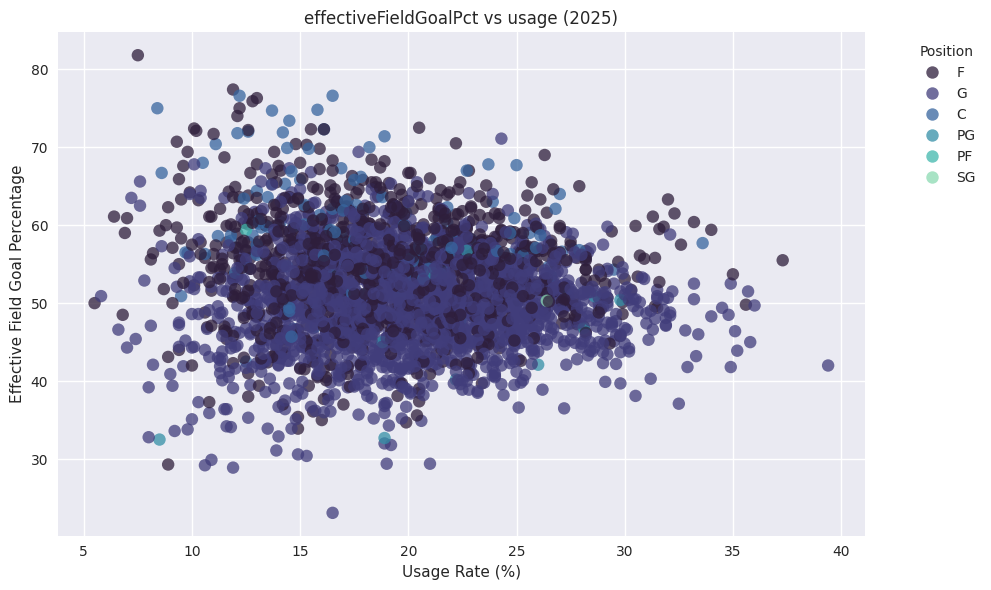

In [15]:
# 📈 Scatter plot
plot_df = players.dropna(subset=[SCATTER_X, SCATTER_Y]).copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x=SCATTER_X, y=SCATTER_Y, hue=SCATTER_HUE, alpha=0.75, s=80, edgecolor='none')
plt.title(f"{SCATTER_Y} vs {SCATTER_X} ({TARGET_SEASON})")
plt.xlabel('Usage Rate (%)')
plt.ylabel('Effective Field Goal Percentage')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

if HIGHLIGHT_PLAYER and HIGHLIGHT_PLAYER in plot_df['name'].values:
    highlight_row = plot_df.loc[plot_df['name'] == HIGHLIGHT_PLAYER].iloc[0]
    plt.scatter(highlight_row[SCATTER_X], highlight_row[SCATTER_Y], color='crimson', s=150, edgecolor='white', linewidth=1.5)
    plt.text(
        highlight_row[SCATTER_X],
        highlight_row[SCATTER_Y],
        HIGHLIGHT_PLAYER,
        color='crimson',
        fontsize=10,
        fontweight='bold',
        ha='left',
        va='bottom'
    )

plt.tight_layout()
plt.show()



## 📋 Position averages
Comparing positions normalizes expectations. A center and a point guard contribute in different ways, and the table shows what counts as typical production for each group.

Compare how guards, wings, and bigs contribute on a per-40 basis.


In [17]:
# 📋 Position summary
position_summary = (
    players.groupby('position', dropna=False)
    .agg(
        players=('name', 'nunique'),
        avg_usage=('usage', 'mean'),
        pts_per40=('points_per40', 'mean'),
        reb_per40=('rebounds_per40', 'mean'),
        ast_per40=('assists_per40', 'mean'),
        efg_pct=('effectiveFieldGoalPct', 'mean'),
        off_rating=('offensiveRating', 'mean')
    )
    .reset_index()
    .sort_values('pts_per40', ascending=False)
)

display(position_summary.round(2))



,position,players,avg_usage,pts_per40,reb_per40,ast_per40,efg_pct,off_rating
5,SG,1,26.40,21.55,4.17,2.08,50.30,112.00
4,PG,11,22.06,14.96,3.54,4.38,45.66,101.79
0,C,132,18.36,14.41,10.24,1.85,59.18,114.24
2,G,1840,20.20,14.37,4.98,3.09,49.67,107.66
1,F,1050,19.03,14.29,8.47,1.88,54.23,110.98
3,PF,1,12.50,10.00,10.67,1.78,59.40,111.60


## ✅ Next steps
Save any standout names you find. They will become key characters in player comparison or matchup notebooks later in the series.

- Layer in the game-level dataset to build rolling rate stats across custom date ranges.
- Merge shooting splits from `player_season_shooting_stats` to unlock efficiency context by zone.
- Export `leaderboard_tables` to CSV for sharing with analysts or broadcasting partners.
